## Try to maximize the likelihood (CMB parameterization)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=15
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 15 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_15/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.7654E-09, n_s = 9.6590E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
# specify redshift range
z_max=4
# do not use test_sim_num that was used in generating mock data
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_data.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0","ln_kF_0"]
    like_param_limits=[[-0.2, 0.2],[-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0",
            "ln_gamma_0","ln_kF_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.05], [-0.2, 0.2],
            [-0.2, 0.2], [-0.2, 0.2], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5,
                            emu_cov_factor=1)

In [9]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.9750000000000001
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
starting chi2 867.1294844094404


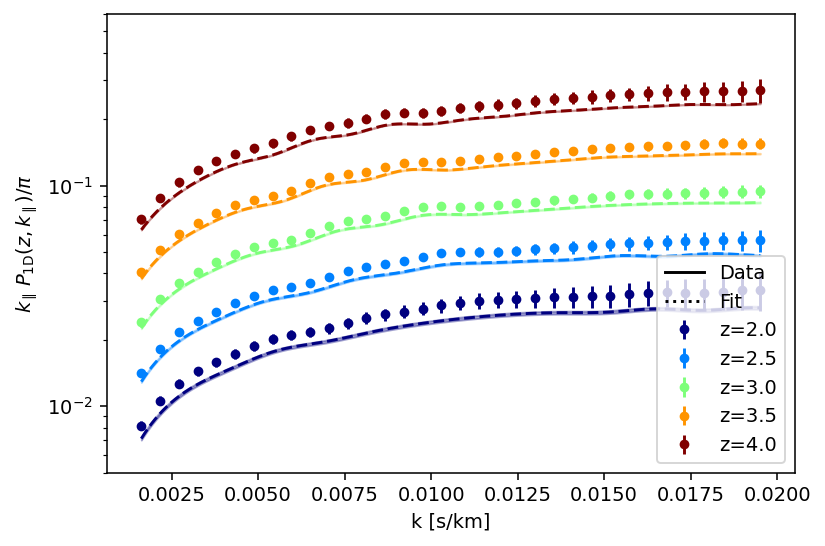

In [10]:
like.plot_p1d(plot_every_iz=2)

# Run minimiser

In [11]:
from scipy.optimize import minimize

In [12]:
def callbackF(xk):
    chi2=like.get_chi2(values=xk)
    print('chi2=',chi2,'at x=',xk)
    for par in like.parameters_from_sampling_point(xk):
        print(par.info_str())

In [13]:
results=minimize(like.minus_log_prob, x0=theta,method = 'Nelder-Mead',
                 options={'disp':True,'maxiter':1000},callback=callbackF)

chi2= 636.177546826585 at x= [0.5   0.525 0.5   0.5   0.5   0.5  ]
As = 1.9999999999999997e-09
ns = 0.97875
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
ln_kF_0 = 0.0
chi2= 494.76207190145726 at x= [0.51666667 0.51666667 0.51666667 0.51666667 0.4875     0.51666667]
As = 2.0333333333333333e-09
ns = 0.9775
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2= 494.76207190145726 at x= [0.51666667 0.51666667 0.51666667 0.51666667 0.4875     0.51666667]
As = 2.0333333333333333e-09
ns = 0.9775
ln_tau_0 = 0.006666666666666654
ln_sigT_kms_0 = 0.006666666666666654
ln_gamma_0 = -0.004999999999999977
ln_kF_0 = 0.006666666666666654
chi2= 237.36894214162604 at x= [0.53333333 0.53333333 0.53333333 0.50416667 0.475      0.47083333]
As = 2.066666666666666e-09
ns = 0.98
ln_tau_0 = 0.01333333333333328
ln_sigT_kms_0 = 0.0016666666666666496
ln_gamma_0 = -0.009999999999999953
ln_kF_0 = -0.011666666666666714
chi2= 

chi2= 22.693075671479406 at x= [0.53890872 0.61941828 0.60731508 0.45732164 0.42398763 0.53322806]
As = 2.077817432148313e-09
ns = 0.9929127412642389
ln_tau_0 = 0.0429260333644228
ln_sigT_kms_0 = -0.01707134447374692
ln_gamma_0 = -0.030404947252689662
ln_kF_0 = 0.013291222427690652
chi2= 22.693075671479406 at x= [0.53890872 0.61941828 0.60731508 0.45732164 0.42398763 0.53322806]
As = 2.077817432148313e-09
ns = 0.9929127412642389
ln_tau_0 = 0.0429260333644228
ln_sigT_kms_0 = -0.01707134447374692
ln_gamma_0 = -0.030404947252689662
ln_kF_0 = 0.013291222427690652
chi2= 23.015372005667228 at x= [0.54269177 0.60722741 0.5912594  0.47080218 0.37937252 0.59034851]
As = 2.0853835497423804e-09
ns = 0.9910841121941959
ln_tau_0 = 0.03650376024962884
ln_sigT_kms_0 = -0.011679129203689659
ln_gamma_0 = -0.048250990004267746
ln_kF_0 = 0.03613940283966857
chi2= 20.33181448078071 at x= [0.54637936 0.61997535 0.61134338 0.43648982 0.39289143 0.60031168]
As = 2.092758726284329e-09
ns = 0.9929963026152058


chi2= 18.1938528713965 at x= [0.49356493 0.61628346 0.63391305 0.41138676 0.4339663  0.59628913]
As = 1.98712986457378e-09
ns = 0.9924425186723183
ln_tau_0 = 0.053565219752259974
ln_sigT_kms_0 = -0.03544529639294139
ln_gamma_0 = -0.026413479681525853
ln_kF_0 = 0.03851565279957203
chi2= 18.152341746540518 at x= [0.49888359 0.61354739 0.62804586 0.42156607 0.40243875 0.62194924]
As = 1.9977671743877082e-09
ns = 0.9920321088934352
ln_tau_0 = 0.05121834574601375
ln_sigT_kms_0 = -0.03137357086395051
ln_gamma_0 = -0.03902450103009403
ln_kF_0 = 0.04877969448279895
chi2= 18.152341746540518 at x= [0.49888359 0.61354739 0.62804586 0.42156607 0.40243875 0.62194924]
As = 1.9977671743877082e-09
ns = 0.9920321088934352
ln_tau_0 = 0.05121834574601375
ln_sigT_kms_0 = -0.03137357086395051
ln_gamma_0 = -0.03902450103009403
ln_kF_0 = 0.04877969448279895
chi2= 18.152341746540518 at x= [0.49888359 0.61354739 0.62804586 0.42156607 0.40243875 0.62194924]
As = 1.9977671743877082e-09
ns = 0.9920321088934352
ln

chi2= 7.3520871005670125 at x= [0.35115421 0.53792524 0.77509122 0.42055202 0.50504213 0.41137435]
As = 1.7023084219174432e-09
ns = 0.9806887863644351
ln_tau_0 = 0.11003648863317983
ln_sigT_kms_0 = -0.03177919306043986
ln_gamma_0 = 0.0020168535495785345
ln_kF_0 = -0.03545026086621467
chi2= 7.3520871005670125 at x= [0.35115421 0.53792524 0.77509122 0.42055202 0.50504213 0.41137435]
As = 1.7023084219174432e-09
ns = 0.9806887863644351
ln_tau_0 = 0.11003648863317983
ln_sigT_kms_0 = -0.03177919306043986
ln_gamma_0 = 0.0020168535495785345
ln_kF_0 = -0.03545026086621467
chi2= 7.3520871005670125 at x= [0.35115421 0.53792524 0.77509122 0.42055202 0.50504213 0.41137435]
As = 1.7023084219174432e-09
ns = 0.9806887863644351
ln_tau_0 = 0.11003648863317983
ln_sigT_kms_0 = -0.03177919306043986
ln_gamma_0 = 0.0020168535495785345
ln_kF_0 = -0.03545026086621467
chi2= 6.7785097929053 at x= [0.3206519  0.52999171 0.7943008  0.4096899  0.50937365 0.40886619]
As = 1.6413037950882661e-09
ns = 0.97949875584425

chi2= 5.74411614057918 at x= [0.35146513 0.43780974 0.75990168 0.53634481 0.3524601  0.48941894]
As = 1.7029302501473315e-09
ns = 0.9656714609202515
ln_tau_0 = 0.10396067347877785
ln_sigT_kms_0 = 0.014537925678274666
ln_gamma_0 = -0.059015961410170625
ln_kF_0 = -0.004232424587916561
chi2= 5.74411614057918 at x= [0.35146513 0.43780974 0.75990168 0.53634481 0.3524601  0.48941894]
As = 1.7029302501473315e-09
ns = 0.9656714609202515
ln_tau_0 = 0.10396067347877785
ln_sigT_kms_0 = 0.014537925678274666
ln_gamma_0 = -0.059015961410170625
ln_kF_0 = -0.004232424587916561
chi2= 5.74411614057918 at x= [0.35146513 0.43780974 0.75990168 0.53634481 0.3524601  0.48941894]
As = 1.7029302501473315e-09
ns = 0.9656714609202515
ln_tau_0 = 0.10396067347877785
ln_sigT_kms_0 = 0.014537925678274666
ln_gamma_0 = -0.059015961410170625
ln_kF_0 = -0.004232424587916561
chi2= 5.74411614057918 at x= [0.35146513 0.43780974 0.75990168 0.53634481 0.3524601  0.48941894]
As = 1.7029302501473315e-09
ns = 0.9656714609202515

chi2= 5.167342579399524 at x= [0.35010726 0.42475646 0.75686405 0.55708751 0.31930988 0.49587431]
As = 1.7002145136441164e-09
ns = 0.9637134684709212
ln_tau_0 = 0.10274562189494807
ln_sigT_kms_0 = 0.022835004276415022
ln_gamma_0 = -0.07227604632734891
ln_kF_0 = -0.0016502755695032845
chi2= 5.167342579399524 at x= [0.35010726 0.42475646 0.75686405 0.55708751 0.31930988 0.49587431]
As = 1.7002145136441164e-09
ns = 0.9637134684709212
ln_tau_0 = 0.10274562189494807
ln_sigT_kms_0 = 0.022835004276415022
ln_gamma_0 = -0.07227604632734891
ln_kF_0 = -0.0016502755695032845
chi2= 5.556631961941651 at x= [0.35254949 0.43413495 0.75385952 0.5477316  0.32453059 0.49651842]
As = 1.7050989783443623e-09
ns = 0.9651202418258004
ln_tau_0 = 0.1015438085629578
ln_sigT_kms_0 = 0.019092640223282414
ln_gamma_0 = -0.07018776479676442
ln_kF_0 = -0.0013926310552774268
chi2= 5.556631961941651 at x= [0.35254949 0.43413495 0.75385952 0.5477316  0.32453059 0.49651842]
As = 1.7050989783443623e-09
ns = 0.9651202418258

chi2= 4.786555235201774 at x= [0.34750245 0.44178617 0.7503542  0.54635963 0.28030777 0.48550832]
As = 1.6950049010286931e-09
ns = 0.9662679248332754
ln_tau_0 = 0.10014167896331555
ln_sigT_kms_0 = 0.01854385268738773
ln_gamma_0 = -0.08787689134630905
ln_kF_0 = -0.005796671331661785
chi2= 4.7129683375764 at x= [0.34674641 0.43927292 0.75065374 0.54910295 0.27547636 0.48623966]
As = 1.6934928259723942e-09
ns = 0.9658909384580716
ln_tau_0 = 0.10026149454871947
ln_sigT_kms_0 = 0.019641180274566905
ln_gamma_0 = -0.08980945598876887
ln_kF_0 = -0.00550413507453737
chi2= 4.707020189014766 at x= [0.34614333 0.441519   0.75014758 0.54713379 0.27153465 0.48537826]
As = 1.6922866606219366e-09
ns = 0.9662278505764565
ln_tau_0 = 0.10005903044709225
ln_sigT_kms_0 = 0.0188535152650314
ln_gamma_0 = -0.09138613879376506
ln_kF_0 = -0.00584869437672636
chi2= 4.758881821948666 at x= [0.34738421 0.44243214 0.75004815 0.54604022 0.27638563 0.48511122]
As = 1.6947684129099557e-09
ns = 0.9663648202859705
ln_ta

chi2= 4.748250752793216 at x= [0.34758122 0.44191118 0.74950139 0.54705783 0.27422461 0.48557602]
As = 1.6951624367987056e-09
ns = 0.966286676834247
ln_tau_0 = 0.09980055525142717
ln_sigT_kms_0 = 0.01882313283920864
ln_gamma_0 = -0.09031015420939076
ln_kF_0 = -0.0057695920177625315
chi2= 4.748250752793216 at x= [0.34758122 0.44191118 0.74950139 0.54705783 0.27422461 0.48557602]
As = 1.6951624367987056e-09
ns = 0.966286676834247
ln_tau_0 = 0.09980055525142717
ln_sigT_kms_0 = 0.01882313283920864
ln_gamma_0 = -0.09031015420939076
ln_kF_0 = -0.0057695920177625315
chi2= 4.748250752793216 at x= [0.34758122 0.44191118 0.74950139 0.54705783 0.27422461 0.48557602]
As = 1.6951624367987056e-09
ns = 0.966286676834247
ln_tau_0 = 0.09980055525142717
ln_sigT_kms_0 = 0.01882313283920864
ln_gamma_0 = -0.09031015420939076
ln_kF_0 = -0.0057695920177625315
chi2= 4.726077376057293 at x= [0.34716986 0.44169774 0.74964615 0.54723865 0.27313622 0.48539802]
As = 1.694339725538491e-09
ns = 0.9662546606314675
ln

chi2= 4.740414459142778 at x= [0.3468785  0.44297304 0.7498503  0.54392887 0.2756558  0.48444997]
As = 1.6937570031694604e-09
ns = 0.9664459556179387
ln_tau_0 = 0.09994012171012534
ln_sigT_kms_0 = 0.017571549381055707
ln_gamma_0 = -0.08973767801338806
ln_kF_0 = -0.0062200104588296945
chi2= 4.8089726604749305 at x= [0.34781572 0.44186753 0.74932587 0.54496236 0.27595462 0.48662961]
As = 1.6956314490973554e-09
ns = 0.9662801294140827
ln_tau_0 = 0.09973034778304724
ln_sigT_kms_0 = 0.01798494543109097
ln_gamma_0 = -0.08961815064638429
ln_kF_0 = -0.0053481564997665265
chi2= 4.8089726604749305 at x= [0.34781572 0.44186753 0.74932587 0.54496236 0.27595462 0.48662961]
As = 1.6956314490973554e-09
ns = 0.9662801294140827
ln_tau_0 = 0.09973034778304724
ln_sigT_kms_0 = 0.01798494543109097
ln_gamma_0 = -0.08961815064638429
ln_kF_0 = -0.0053481564997665265
chi2= 4.791959593522018 at x= [0.34751676 0.44174965 0.74975713 0.54446881 0.27781625 0.48597598]
As = 1.6950335151925901e-09
ns = 0.966262447917

chi2= 4.8010882361275975 at x= [0.34440596 0.44495537 0.75021293 0.51160992 0.27217307 0.48315789]
As = 1.6888119228721718e-09
ns = 0.9667433048349265
ln_tau_0 = 0.1000851716858337
ln_sigT_kms_0 = 0.00464396731810765
ln_gamma_0 = -0.09113077170822081
ln_kF_0 = -0.006736844936649333
chi2= 4.8010882361275975 at x= [0.34440596 0.44495537 0.75021293 0.51160992 0.27217307 0.48315789]
As = 1.6888119228721718e-09
ns = 0.9667433048349265
ln_tau_0 = 0.1000851716858337
ln_sigT_kms_0 = 0.00464396731810765
ln_gamma_0 = -0.09113077170822081
ln_kF_0 = -0.006736844936649333
chi2= 4.8010882361275975 at x= [0.34440596 0.44495537 0.75021293 0.51160992 0.27217307 0.48315789]
As = 1.6888119228721718e-09
ns = 0.9667433048349265
ln_tau_0 = 0.1000851716858337
ln_sigT_kms_0 = 0.00464396731810765
ln_gamma_0 = -0.09113077170822081
ln_kF_0 = -0.006736844936649333
chi2= 5.058806243784341 at x= [0.34669224 0.44323747 0.74979821 0.50213027 0.27933287 0.48821561]
As = 1.6933844875376927e-09
ns = 0.9664856208968055
l

chi2= 4.469883518222799 at x= [0.33475946 0.43906665 0.75669544 0.39425113 0.23797967 0.47600527]
As = 1.66951892416198e-09
ns = 0.9658599979248252
ln_tau_0 = 0.10267817594677187
ln_sigT_kms_0 = -0.042299546162722995
ln_gamma_0 = -0.10480813066890092
ln_kF_0 = -0.009597890488201172
chi2= 4.469883518222799 at x= [0.33475946 0.43906665 0.75669544 0.39425113 0.23797967 0.47600527]
As = 1.66951892416198e-09
ns = 0.9658599979248252
ln_tau_0 = 0.10267817594677187
ln_sigT_kms_0 = -0.042299546162722995
ln_gamma_0 = -0.10480813066890092
ln_kF_0 = -0.009597890488201172
chi2= 4.469883518222799 at x= [0.33475946 0.43906665 0.75669544 0.39425113 0.23797967 0.47600527]
As = 1.66951892416198e-09
ns = 0.9658599979248252
ln_tau_0 = 0.10267817594677187
ln_sigT_kms_0 = -0.042299546162722995
ln_gamma_0 = -0.10480813066890092
ln_kF_0 = -0.009597890488201172
chi2= 4.469883518222799 at x= [0.33475946 0.43906665 0.75669544 0.39425113 0.23797967 0.47600527]
As = 1.66951892416198e-09
ns = 0.9658599979248252
ln_

chi2= 4.779024532144419 at x= [0.3352559  0.44845972 0.75841819 0.26652645 0.23841674 0.47124185]
As = 1.6705118042559501e-09
ns = 0.9672689572630262
ln_tau_0 = 0.10336727435429494
ln_sigT_kms_0 = -0.09338941825302616
ln_gamma_0 = -0.10463330256858866
ln_kF_0 = -0.011503260129082843
chi2= 4.779024532144419 at x= [0.3352559  0.44845972 0.75841819 0.26652645 0.23841674 0.47124185]
As = 1.6705118042559501e-09
ns = 0.9672689572630262
ln_tau_0 = 0.10336727435429494
ln_sigT_kms_0 = -0.09338941825302616
ln_gamma_0 = -0.10463330256858866
ln_kF_0 = -0.011503260129082843
chi2= 4.779024532144419 at x= [0.3352559  0.44845972 0.75841819 0.26652645 0.23841674 0.47124185]
As = 1.6705118042559501e-09
ns = 0.9672689572630262
ln_tau_0 = 0.10336727435429494
ln_sigT_kms_0 = -0.09338941825302616
ln_gamma_0 = -0.10463330256858866
ln_kF_0 = -0.011503260129082843
chi2= 4.779024532144419 at x= [0.3352559  0.44845972 0.75841819 0.26652645 0.23841674 0.47124185]
As = 1.6705118042559501e-09
ns = 0.967268957263026

chi2= 4.6717023759336325 at x= [0.33840293 0.44428841 0.75664918 0.28335089 0.2390983  0.47328763]
As = 1.6768058553908486e-09
ns = 0.9666432617199141
ln_tau_0 = 0.1026596704664261
ln_sigT_kms_0 = -0.08665964535182642
ln_gamma_0 = -0.10436068089840714
ln_kF_0 = -0.010684946873512235
chi2= 4.6717023759336325 at x= [0.33840293 0.44428841 0.75664918 0.28335089 0.2390983  0.47328763]
As = 1.6768058553908486e-09
ns = 0.9666432617199141
ln_tau_0 = 0.1026596704664261
ln_sigT_kms_0 = -0.08665964535182642
ln_gamma_0 = -0.10436068089840714
ln_kF_0 = -0.010684946873512235
chi2= 4.601393108512059 at x= [0.33770765 0.44477596 0.75719049 0.27702822 0.23688834 0.47142656]
As = 1.6754153038460302e-09
ns = 0.9667163938302302
ln_tau_0 = 0.10287619733691133
ln_sigT_kms_0 = -0.0891887116188954
ln_gamma_0 = -0.10524466459643861
ln_kF_0 = -0.011429375342426218
chi2= 4.601393108512059 at x= [0.33770765 0.44477596 0.75719049 0.27702822 0.23688834 0.47142656]
As = 1.6754153038460302e-09
ns = 0.9667163938302302

chi2= 4.542900494529627 at x= [0.3390808  0.44347948 0.75605246 0.28039048 0.23399598 0.4720982 ]
As = 1.6781616096383505e-09
ns = 0.966521921950973
ln_tau_0 = 0.1024209825589481
ln_sigT_kms_0 = -0.08784380881026449
ln_gamma_0 = -0.10640160708291993
ln_kF_0 = -0.011160719328378033
chi2= 4.542900494529627 at x= [0.3390808  0.44347948 0.75605246 0.28039048 0.23399598 0.4720982 ]
As = 1.6781616096383505e-09
ns = 0.966521921950973
ln_tau_0 = 0.1024209825589481
ln_sigT_kms_0 = -0.08784380881026449
ln_gamma_0 = -0.10640160708291993
ln_kF_0 = -0.011160719328378033
chi2= 4.542900494529627 at x= [0.3390808  0.44347948 0.75605246 0.28039048 0.23399598 0.4720982 ]
As = 1.6781616096383505e-09
ns = 0.966521921950973
ln_tau_0 = 0.1024209825589481
ln_sigT_kms_0 = -0.08784380881026449
ln_gamma_0 = -0.10640160708291993
ln_kF_0 = -0.011160719328378033
chi2= 4.578451624318766 at x= [0.33930465 0.4440748  0.75592245 0.27829535 0.23511881 0.47229354]
As = 1.678609305981176e-09
ns = 0.9666112203175548
ln_ta

chi2= 4.565047198085251 at x= [0.33907515 0.4436865  0.75607283 0.27796072 0.23422539 0.47229011]
As = 1.6781502963572241e-09
ns = 0.9665529755950366
ln_tau_0 = 0.10242913267155379
ln_sigT_kms_0 = -0.08881571044964787
ln_gamma_0 = -0.10630984418386924
ln_kF_0 = -0.011083954034191906
chi2= 4.565047198085251 at x= [0.33907515 0.4436865  0.75607283 0.27796072 0.23422539 0.47229011]
As = 1.6781502963572241e-09
ns = 0.9665529755950366
ln_tau_0 = 0.10242913267155379
ln_sigT_kms_0 = -0.08881571044964787
ln_gamma_0 = -0.10630984418386924
ln_kF_0 = -0.011083954034191906
chi2= 4.565047198085251 at x= [0.33907515 0.4436865  0.75607283 0.27796072 0.23422539 0.47229011]
As = 1.6781502963572241e-09
ns = 0.9665529755950366
ln_tau_0 = 0.10242913267155379
ln_sigT_kms_0 = -0.08881571044964787
ln_gamma_0 = -0.10630984418386924
ln_kF_0 = -0.011083954034191906
chi2= 4.565047198085251 at x= [0.33907515 0.4436865  0.75607283 0.27796072 0.23422539 0.47229011]
As = 1.6781502963572241e-09
ns = 0.966552975595036

chi2= 4.564526738931596 at x= [0.33908658 0.44363391 0.75608331 0.27700048 0.23408477 0.47227653]
As = 1.6781731610773434e-09
ns = 0.9665450865968951
ln_tau_0 = 0.10243332376044617
ln_sigT_kms_0 = -0.08919980799720624
ln_gamma_0 = -0.1063660939440986
ln_kF_0 = -0.011089387894560293
chi2= 4.564526738931596 at x= [0.33908658 0.44363391 0.75608331 0.27700048 0.23408477 0.47227653]
As = 1.6781731610773434e-09
ns = 0.9665450865968951
ln_tau_0 = 0.10243332376044617
ln_sigT_kms_0 = -0.08919980799720624
ln_gamma_0 = -0.1063660939440986
ln_kF_0 = -0.011089387894560293
chi2= 4.564526738931596 at x= [0.33908658 0.44363391 0.75608331 0.27700048 0.23408477 0.47227653]
As = 1.6781731610773434e-09
ns = 0.9665450865968951
ln_tau_0 = 0.10243332376044617
ln_sigT_kms_0 = -0.08919980799720624
ln_gamma_0 = -0.1063660939440986
ln_kF_0 = -0.011089387894560293
chi2= 4.565785846929188 at x= [0.33909088 0.44360596 0.75609204 0.27698061 0.23415337 0.47229867]
As = 1.6781817526919044e-09
ns = 0.9665408946189242
l

In [14]:
print('maximum posterior =',-results.fun)
callbackF(results.x)

maximum posterior = -35.800304221347304
chi2= 4.5654941325880465 at x= [0.33910037 0.44359665 0.75608458 0.27705472 0.23414012 0.47230755]
As = 1.6782007390069366e-09
ns = 0.9665394977002392
ln_tau_0 = 0.10243383283634266
ln_sigT_kms_0 = -0.08917811356303083
ln_gamma_0 = -0.10634395001836822
ln_kF_0 = -0.01107697919707698


In [15]:
# compare to truth
sim_cosmo=data.mock_sim.sim_cosmo
print('true As =',sim_cosmo.InitPower.As)
print('true ns =',sim_cosmo.InitPower.ns)

true As = 1.765434e-09
true ns = 0.965899


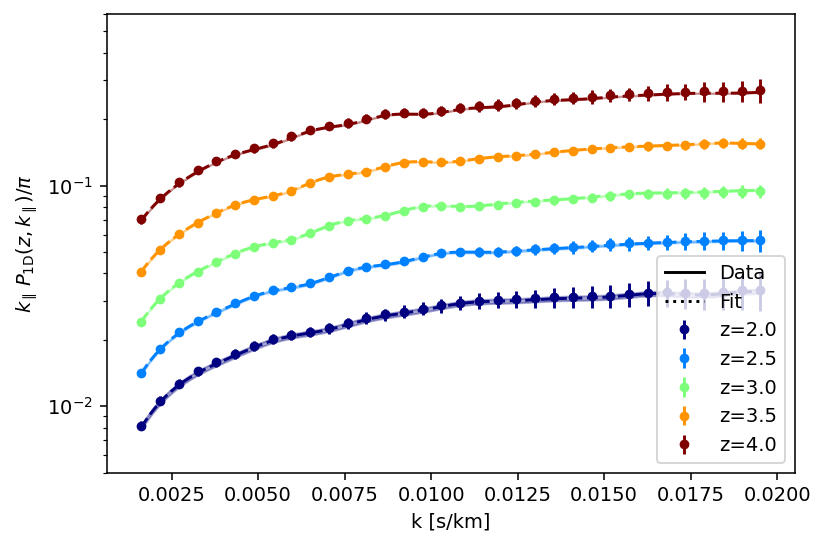

In [16]:
like.plot_p1d(plot_every_iz=2,values=results.x)